# <font color="red">Boston Housing Prediction</font>

## Import the Library

In [1]:
# Data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Utilities
import joblib
import math
import os
import json
from datetime import datetime

## Trained Model and History Saving

These code are used to manage the best model and its performance for reuse or further research purpose

### Directory

In [2]:
# Model tracking configuration
MODEL_REGISTRY_FILE = "history_registry/model_registry_regression.csv"
MODELS_DIR = "saved_models_regression"

### Define the Registry or History File

In [3]:
def load_or_create_registry_regression():
    """Load existing model registry or create new one"""
    try:
        return pd.read_csv(MODEL_REGISTRY_FILE)
    except FileNotFoundError:
        return pd.DataFrame(columns=[
            'model_name', 'mse', 'mae', 'rmse', 'r2', 'timestamp', 
            'model_path', 'scaler_path', 'parameters'
        ])

### Model Saving only for the Best Performance

In [4]:
def save_model_if_better_regression(model_name, model, scaler, mse, mae, rmse, r2, parameters=None):
    """Save model only if it performs better than existing version"""
    
    # Create directories
    os.makedirs(MODELS_DIR, exist_ok=True)
    os.makedirs(os.path.dirname(MODEL_REGISTRY_FILE), exist_ok=True)
    
    # Load registry
    registry = load_or_create_registry_regression()
    
    # Check if model exists
    existing_model = registry[registry['model_name'] == model_name]
    
    should_save = False
    old_model_path = None
    old_scaler_path = None
    
    if existing_model.empty:
        print(f"{model_name}: First time training - saving model")
        should_save = True
    else:
        existing_mse = existing_model['mse'].iloc[0]
        existing_r2 = existing_model['r2'].iloc[0]
        
        # Store old file paths for deletion
        old_model_path = existing_model['model_path'].iloc[0]
        old_scaler_path = existing_model['scaler_path'].iloc[0]
        
        # Check if current model is better (lower MSE and higher R2)
        if mse < existing_mse and r2 > existing_r2:
            print(f"{model_name}: Better performance - updating model")
            print(f"   MSE: {existing_mse:.4f} → {mse:.4f} (↓)")
            print(f"   R2:  {existing_r2:.4f} → {r2:.4f} (↑)")
            should_save = True
        else:
            print(f"{model_name}: No improvement - keeping existing model")
            print(f"   Current MSE: {mse:.4f} vs Best: {existing_mse:.4f}")
            print(f"   Current R2:  {r2:.4f} vs Best: {existing_r2:.4f}")
    
    if should_save:
        # Delete old model files if they exist
        if old_model_path and os.path.exists(old_model_path):
            try:
                os.remove(old_model_path)
                print(f"    Deleted old model: {old_model_path}")
            except Exception as e:
                print(f"    Warning: Could not delete old model file: {e}")
                
        if old_scaler_path and os.path.exists(old_scaler_path):
            try:
                os.remove(old_scaler_path)
                print(f"    Deleted old scaler: {old_scaler_path}")
            except Exception as e:
                print(f"    Warning: Could not delete old scaler file: {e}")
        
        # Save new model and scaler
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_filename = f"{model_name.lower().replace(' ', '_')}_{timestamp}.pkl"
        scaler_filename = f"{model_name.lower().replace(' ', '_')}_scaler_{timestamp}.pkl"
        
        model_path = os.path.join(MODELS_DIR, model_filename)
        scaler_path = os.path.join(MODELS_DIR, scaler_filename)
        
        joblib.dump(model, model_path)
        joblib.dump(scaler, scaler_path)
        
        # Remove old entry from registry (if exists)
        registry = registry[registry['model_name'] != model_name]
        
        # Add new entry to registry
        new_entry = pd.DataFrame([{
            'model_name': model_name,
            'mse': mse,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'timestamp': timestamp,
            'model_path': model_path,
            'scaler_path': scaler_path,
            'parameters': json.dumps(parameters) if parameters else None
        }])
        
        registry = pd.concat([registry, new_entry], ignore_index=True)
        registry.to_csv(MODEL_REGISTRY_FILE, index=False)
        
        print(f"    New model saved to: {model_path}")
        print(f"    New scaler saved to: {scaler_path}")
    
    return should_save

### Show the history in descending order of R2

In [5]:
def show_model_registry_regression():
    """Display current model registry in descending order of R2"""
    try:
        registry = pd.read_csv(MODEL_REGISTRY_FILE)
        if not registry.empty:
            # Sort by R2 in descending order (best models first)
            registry_sorted = registry.sort_values('r2', ascending=False)
            
            print("\n" + "="*80)
            print("MODEL REGISTRY - BEST PERFORMING MODELS (Sorted by R2)")
            print("="*80)
            display_cols = ['model_name', 'mse', 'mae', 'rmse', 'r2', 'timestamp']
            print(registry_sorted[display_cols].to_string(index=False))
        else:
            print("No models saved yet.")
    except FileNotFoundError:
        print("No model registry found.")

### For Model Parameters

In [6]:
def view_model_parameters_regression(model_name=None):
    """View parameters of saved models"""
    try:
        registry = pd.read_csv(MODEL_REGISTRY_FILE)
        
        if model_name:
            model_info = registry[registry['model_name'] == model_name]
            if model_info.empty:
                print(f"No model found with name: {model_name}")
                return
            
            params_json = model_info['parameters'].iloc[0]
            if params_json:
                import json
                params = json.loads(params_json)
                print(f"\n{model_name} Parameters:")
                print("="*50)
                
                # If it's a tuned model, show best_params prominently
                if 'best_params' in params:
                    print("OPTIMIZED PARAMETERS:")
                    for key, value in params['best_params'].items():
                        print(f"   {key}: {value}")
                    print(f"\nCross-validation score: {params.get('cv_score', 'N/A')}")
                    
                    # Also show all parameters of the best model
                    if 'all_params' in params:
                        print(f"\nCOMPLETE PARAMETER SET:")
                        all_params = params['all_params']
                        for key, value in sorted(all_params.items()):
                            print(f"   {key}: {value}")
                else:
                    # Show ALL parameters for regular models
                    print("MODEL PARAMETERS:")
                    for key, value in sorted(params.items()):
                        print(f"   {key}: {value}")
            else:
                print("No parameters saved for this model")
        else:
            # Show all models with ALL their parameters
            print("\n" + "="*80)
            print("ALL SAVED MODELS AND THEIR PARAMETERS")
            print("="*80)
            
            # Sort by R2 score descending (best first)
            registry_sorted = registry.sort_values('r2', ascending=False)
            
            for _, row in registry_sorted.iterrows():
                print(f"\n{row['model_name']}")
                print(f"   Performance: MSE={row['mse']:.4f}, R2={row['r2']:.4f}")
                
                if row['parameters']:
                    import json
                    params = json.loads(row['parameters'])
                    
                    if 'best_params' in params:
                        print("   Optimized Parameters:")
                        for key, value in params['best_params'].items():
                            print(f"      {key}: {value}")
                        print(f"   CV Score: {params.get('cv_score', 'N/A'):.4f}")
                    else:
                        print("   All Parameters:")
                        # Show ALL parameters, not just first 8
                        for key, value in sorted(params.items()):
                            if key not in ['algorithm']:  # Skip meta info only
                                print(f"      {key}: {value}")
                else:
                    print("   No parameters saved")
                print(f"   Saved: {row['timestamp']}")
                
    except Exception as e:
        print(f"Error viewing parameters: {e}")

# Usage examples:
# view_model_parameters_regression()  # View all models with their specific parameters
# view_model_parameters_regression("Linear Regression")  # View Linear Regression parameters
# view_model_parameters_regression("SVR")  # View SVR parameters
# view_model_parameters_regression("Random Forest Tuned")  # View tuned Random Forest parameters

### For Testing the Best Model and Reuse

In [7]:
# Function to load the best model
def load_best_model_regression(model_name):
    """Load the best saved model and scaler"""
    try:
        registry = pd.read_csv(MODEL_REGISTRY_FILE)
        model_info = registry[registry['model_name'] == model_name]
        
        if model_info.empty:
            print(f"No saved model found for: {model_name}")
            return None, None
            
        model_path = model_info['model_path'].iloc[0]
        scaler_path = model_info['scaler_path'].iloc[0]
        
        model = joblib.load(model_path)
        scaler = joblib.load(scaler_path)
        
        print(f" Loaded {model_name} from {model_path}")
        return model, scaler
        
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None

# Example usage:
# print("\n" + "="*50)
# print("USAGE EXAMPLES")
# print("="*50)
# print("# To load a specific model:")
# print("model, scaler = load_best_model('Random Forest Tuned')")
# print("\n# To make predictions:")
# print("# scaled_data = scaler.transform(new_data)")
# print("# predictions = model.predict(scaled_data)")

## Import the Datasets

In [8]:
# Load the dataset
boston = pd.read_csv('Datasets/BostonHousingData.csv')
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [9]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [10]:
boston.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Datasets Description

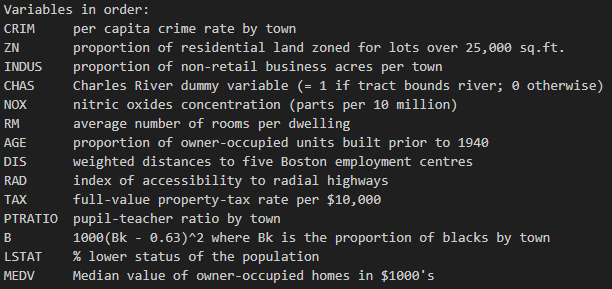

### Handle Null Value

In [11]:
boston.isnull().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [12]:
# Fill missing values as specified
boston['CRIM'] = boston['CRIM'].fillna(boston['CRIM'].mean())
boston['ZN'] = boston['ZN'].fillna(boston['ZN'].mean())
boston['INDUS'] = boston['INDUS'].fillna(boston['INDUS'].mean())
boston['CHAS'] = boston['CHAS'].fillna(boston['CHAS'].mode()[0])
boston['AGE'] = boston['AGE'].fillna(boston['AGE'].mean())
boston['LSTAT'] = boston['LSTAT'].fillna(boston['LSTAT'].mean())

In [13]:
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

### Check for Duplicate

In [14]:
duplicates =  boston[boston.duplicated(keep='first')]
duplicates

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV


No Duplicate Data

### Add MEDV_Class for Classification Problem

In [15]:
# Calculate percentiles for MEDV
low_threshold = boston['MEDV'].quantile(0.25)
high_threshold = boston['MEDV'].quantile(0.75)

def classify_medv(value):
    if value <= low_threshold:
        return 'Low'
    elif value <= high_threshold:
        return 'Medium'
    else:
        return 'High'

boston['MEDV_Class'] = boston['MEDV'].apply(classify_medv)

boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,MEDV_Class
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.980000,24.0,Medium
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.140000,21.6,Medium
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.030000,34.7,High
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.940000,33.4,High
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,12.715432,36.2,High


## Data Visualization

### Visualize with Graph

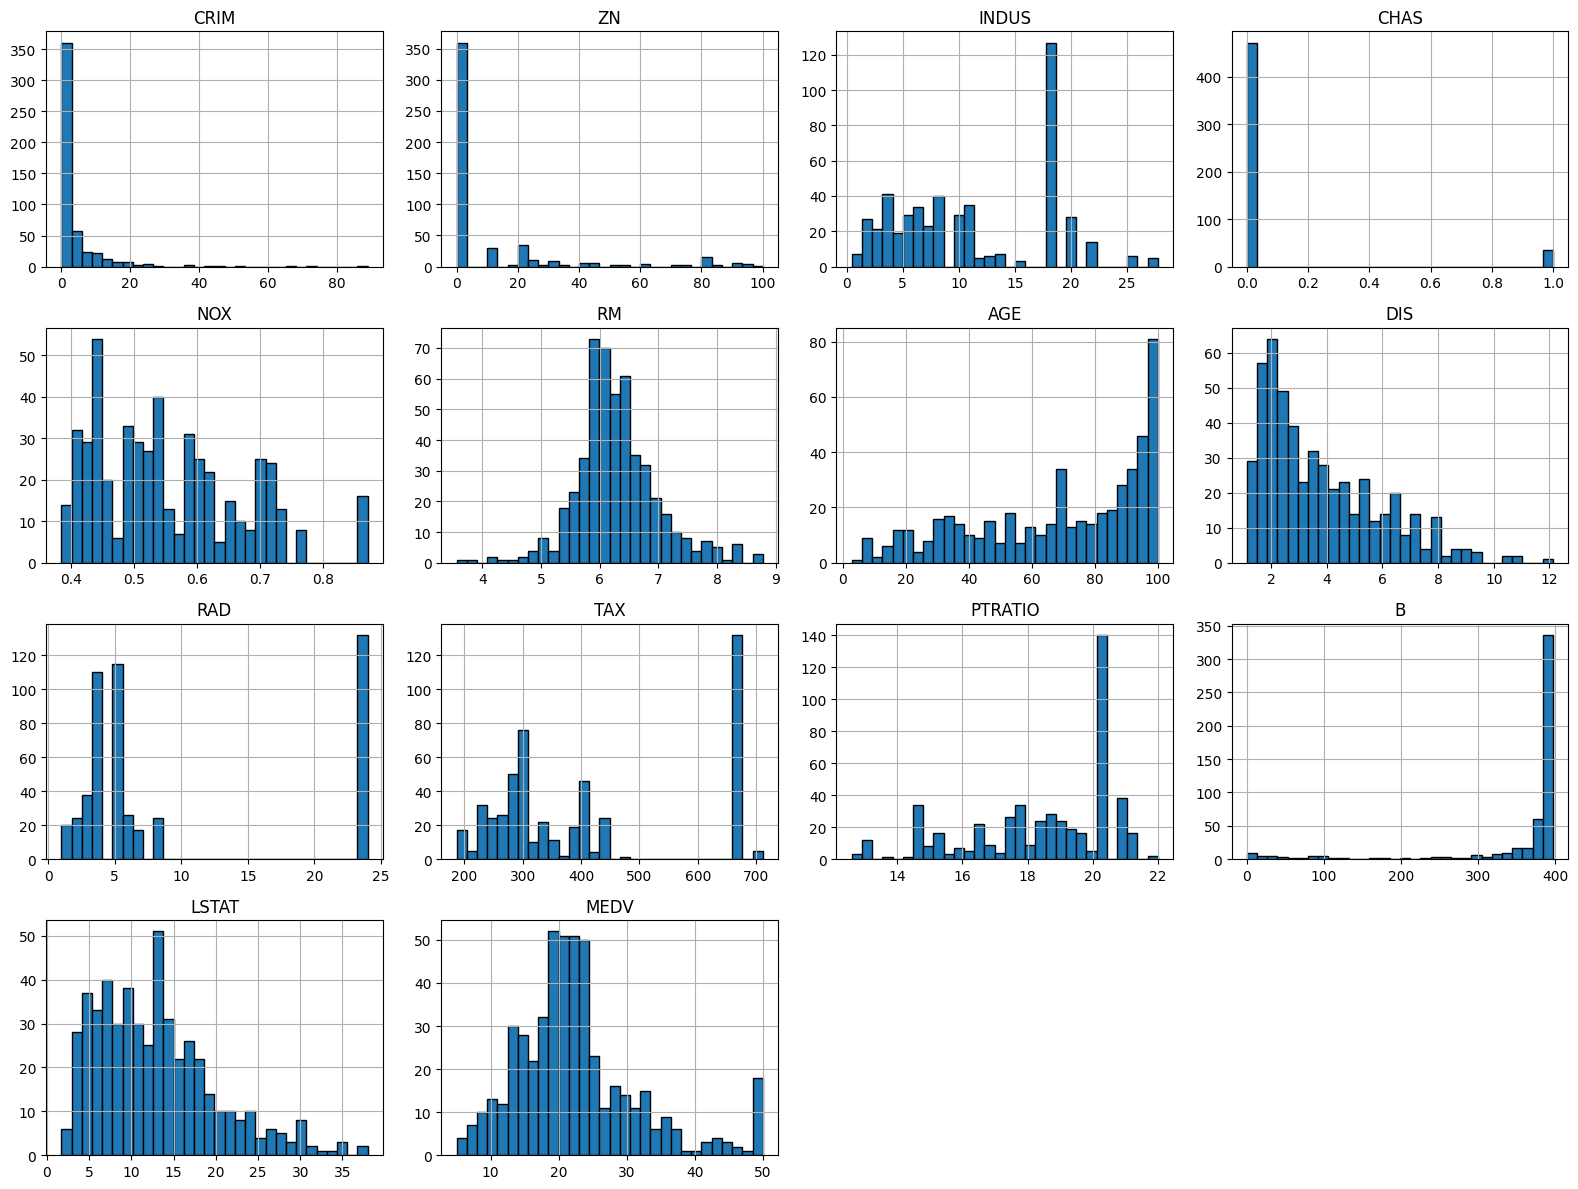

In [16]:
boston.hist(figsize=(16, 12), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

array([[<Axes: xlabel='CRIM', ylabel='CRIM'>,
        <Axes: xlabel='ZN', ylabel='CRIM'>,
        <Axes: xlabel='INDUS', ylabel='CRIM'>,
        <Axes: xlabel='CHAS', ylabel='CRIM'>,
        <Axes: xlabel='NOX', ylabel='CRIM'>,
        <Axes: xlabel='RM', ylabel='CRIM'>,
        <Axes: xlabel='AGE', ylabel='CRIM'>,
        <Axes: xlabel='DIS', ylabel='CRIM'>,
        <Axes: xlabel='RAD', ylabel='CRIM'>,
        <Axes: xlabel='TAX', ylabel='CRIM'>,
        <Axes: xlabel='PTRATIO', ylabel='CRIM'>,
        <Axes: xlabel='B', ylabel='CRIM'>,
        <Axes: xlabel='LSTAT', ylabel='CRIM'>,
        <Axes: xlabel='MEDV', ylabel='CRIM'>],
       [<Axes: xlabel='CRIM', ylabel='ZN'>,
        <Axes: xlabel='ZN', ylabel='ZN'>,
        <Axes: xlabel='INDUS', ylabel='ZN'>,
        <Axes: xlabel='CHAS', ylabel='ZN'>,
        <Axes: xlabel='NOX', ylabel='ZN'>,
        <Axes: xlabel='RM', ylabel='ZN'>,
        <Axes: xlabel='AGE', ylabel='ZN'>,
        <Axes: xlabel='DIS', ylabel='ZN'>,
        <Axes: x

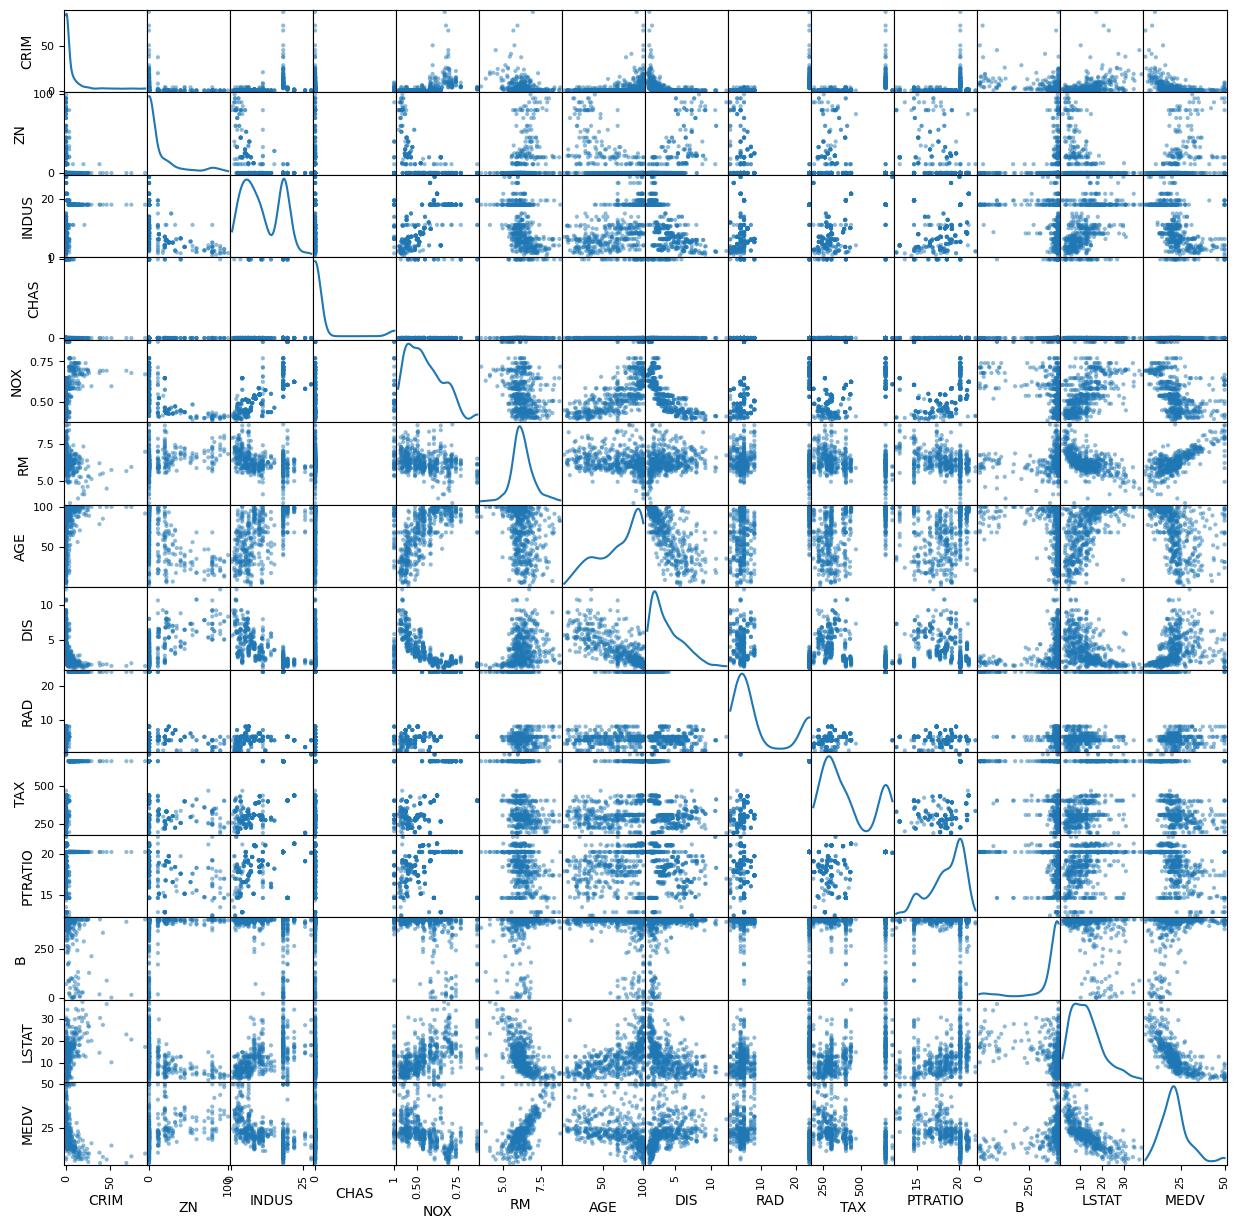

In [17]:
pd.plotting.scatter_matrix(boston, figsize=(15, 15), diagonal='kde')

### Heatmap of the Correlation

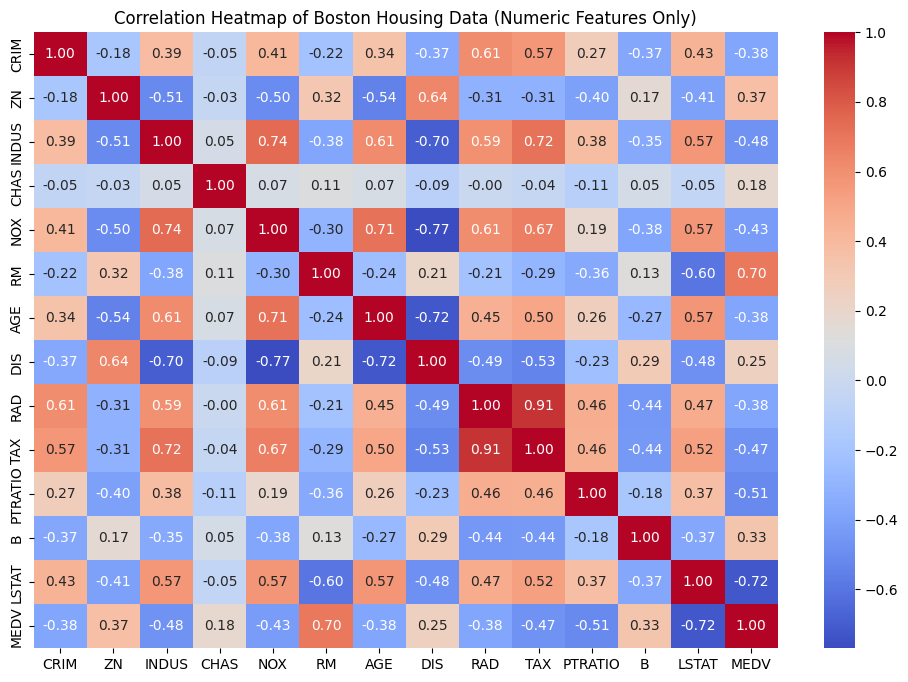

In [18]:
plt.figure(figsize=(12, 8))
corr = boston.select_dtypes(include=[float, int]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Boston Housing Data (Numeric Features Only)')
plt.show()

In [19]:
numeric_cols = boston.select_dtypes(include=[float, int]).columns
correlations = boston[numeric_cols].corr()['MEDV'].sort_values(ascending=False)
print(correlations)

MEDV       1.000000
RM         0.695360
ZN         0.365943
B          0.333461
DIS        0.249929
CHAS       0.183844
CRIM      -0.379695
AGE       -0.380223
RAD       -0.381626
NOX       -0.427321
TAX       -0.468536
INDUS     -0.478657
PTRATIO   -0.507787
LSTAT     -0.721975
Name: MEDV, dtype: float64


### Scatter Plot for the most impact Features

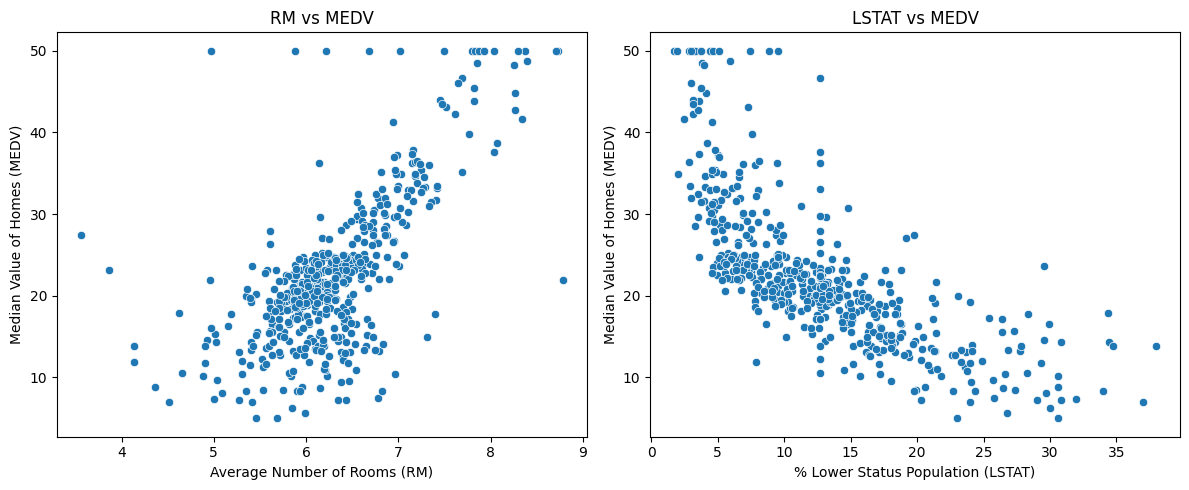

In [20]:
plt.figure(figsize=(12, 5))

# RM vs MEDV
plt.subplot(1, 2, 1)
sns.scatterplot(x='RM', y='MEDV', data=boston)
plt.title('RM vs MEDV')
plt.xlabel('Average Number of Rooms (RM)')
plt.ylabel('Median Value of Homes (MEDV)')

# LSTAT vs MEDV
plt.subplot(1, 2, 2)
sns.scatterplot(x='LSTAT', y='MEDV', data=boston)
plt.title('LSTAT vs MEDV')
plt.xlabel('% Lower Status Population (LSTAT)')
plt.ylabel('Median Value of Homes (MEDV)')

plt.tight_layout()
plt.show()

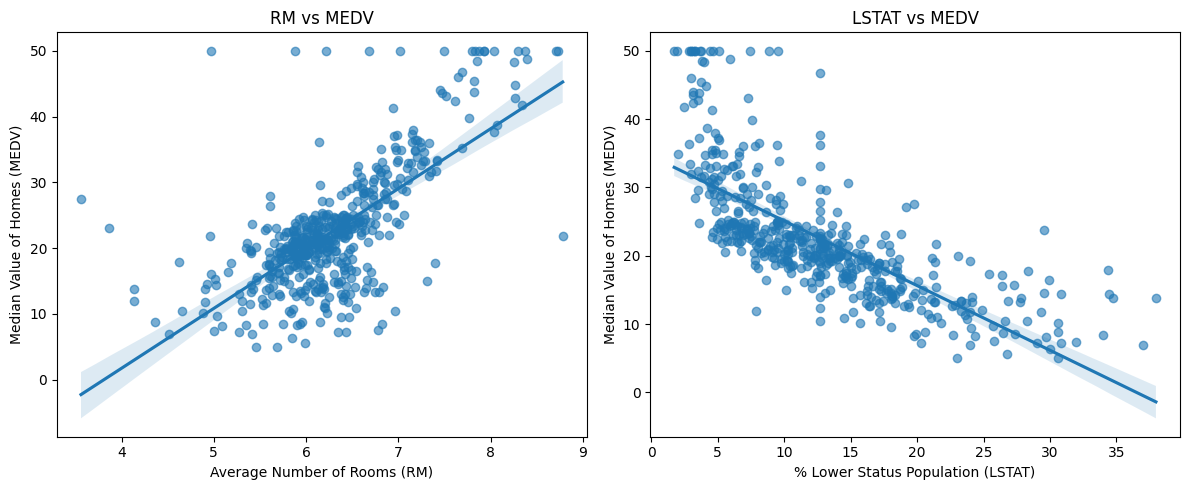

In [21]:
plt.figure(figsize=(12, 5))

# RM vs MEDV with regression line
plt.subplot(1, 2, 1)
sns.regplot(x='RM', y='MEDV', data=boston, scatter_kws={'alpha':0.6})
plt.title('RM vs MEDV')
plt.xlabel('Average Number of Rooms (RM)')
plt.ylabel('Median Value of Homes (MEDV)')

# LSTAT vs MEDV with regression line
plt.subplot(1, 2, 2)
sns.regplot(x='LSTAT', y='MEDV', data=boston, scatter_kws={'alpha':0.6})
plt.title('LSTAT vs MEDV')
plt.xlabel('% Lower Status Population (LSTAT)')
plt.ylabel('Median Value of Homes (MEDV)')

plt.tight_layout()
plt.show()

## Training Regression Model

### Data Split

In [22]:
# Stratified split based on MEDV_Class
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_idx, test_idx in sss.split(boston, boston['MEDV_Class']):
    boston_train = boston.iloc[train_idx]
    boston_test = boston.iloc[test_idx]

In [23]:
# Show the count of each unique class in MEDV_Class
class_counts = boston['MEDV_Class'].value_counts().reset_index()
class_counts.columns = ['MEDV_Class', 'Count']

print("Distribution of data based on MEDV_Class:")
print(class_counts)

Distribution of data based on MEDV_Class:
  MEDV_Class  Count
0     Medium    255
1        Low    127
2       High    124


In [24]:
print("Distribution of MEDV_Class in Training Set:")
print(boston_train['MEDV_Class'].value_counts())

print("\nDistribution of MEDV_Class in Test Set:")
print(boston_test['MEDV_Class'].value_counts())

Distribution of MEDV_Class in Training Set:
MEDV_Class
Medium    204
Low       101
High       99
Name: count, dtype: int64

Distribution of MEDV_Class in Test Set:
MEDV_Class
Medium    51
Low       26
High      25
Name: count, dtype: int64


In [25]:
X_train = boston_train.drop(columns=['MEDV', 'MEDV_Class'])
y_train = boston_train['MEDV']

In [26]:
X_test = boston_test.drop(columns=['MEDV', 'MEDV_Class'])
y_test = boston_test['MEDV']

In [27]:
print("X_train: ", len(X_train))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test))
print("y_test: ", len(y_test))

X_train:  404
y_train:  404

X_test:  102
y_test:  102


### Data Scaling

In [28]:
scaler = MinMaxScaler() #creating an instance

#we can scale the features only, not the target
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
X_train

array([[5.78374450e-04, 0.00000000e+00, 4.92302053e-01, ...,
        4.04255319e-01, 9.89661607e-01, 3.21497920e-01],
       [1.32175642e-01, 0.00000000e+00, 6.46627566e-01, ...,
        8.08510638e-01, 9.51661708e-01, 4.34951456e-01],
       [9.78966488e-02, 0.00000000e+00, 6.46627566e-01, ...,
        8.08510638e-01, 1.00000000e+00, 3.34812760e-01],
       ...,
       [2.24458760e-03, 0.00000000e+00, 3.79398827e-01, ...,
        7.02127660e-01, 9.49669676e-01, 2.20804438e-01],
       [8.37145481e-02, 0.00000000e+00, 6.46627566e-01, ...,
        8.08510638e-01, 9.89359020e-01, 3.62274619e-01],
       [1.24730396e-03, 0.00000000e+00, 7.33137830e-02, ...,
        5.53191489e-01, 9.92990065e-01, 8.04438280e-02]], shape=(404, 13))

In [30]:
X_test

array([[1.45922195e-01, 0.00000000e+00, 6.46627566e-01, ...,
        8.08510638e-01, 8.51883605e-01, 7.78085992e-01],
       [8.01596361e-04, 0.00000000e+00, 4.20454545e-01, ...,
        8.93617021e-01, 1.00000000e+00, 1.03190014e-01],
       [1.39800820e-02, 0.00000000e+00, 2.81524927e-01, ...,
        8.93617021e-01, 7.71748449e-01, 4.26074896e-01],
       ...,
       [1.83387990e-02, 0.00000000e+00, 2.81524927e-01, ...,
        8.93617021e-01, 9.48736699e-01, 5.29819695e-01],
       [1.20651737e-03, 0.00000000e+00, 3.79398827e-01, ...,
        7.02127660e-01, 9.66791064e-01, 1.33148405e-01],
       [5.34319044e-03, 0.00000000e+00, 3.46041056e-01, ...,
        6.17021277e-01, 9.96948913e-01, 2.04160888e-01]], shape=(102, 13))

### Training The Model

#### Linear Regression

In [31]:
LR = LinearRegression()
LR

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [32]:
LR.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [33]:
y_pred = LR.predict(X_test)
y_pred

array([11.79313985, 27.26714293, 14.81463407, 21.45696073, 15.24564389,
       20.5140206 , 27.77453834, 29.67506015, 36.13615564, 22.84406559,
       32.58635833, 14.09855017, 19.64482157, 29.23500732, 25.13566744,
       18.75554935, 25.63014908,  8.7752387 , 19.52122296, 23.92570598,
       14.9507333 ,  2.1385725 ,  6.902059  , 21.29432838, 29.88246075,
       11.83943753, 31.06260984, 25.52633063, 26.49644226, 22.12053797,
       25.97971787, 19.56387495, 17.66504541, 31.20265623, 28.55905891,
       27.30250226, 18.04048703, 37.86920121, 14.43117821, 31.06603537,
       36.22357813, 20.71908817, 31.0221969 , 24.24121587, 39.69067619,
       22.28067503, 20.34903899, 29.1614852 , 28.65516472, 20.49982567,
       13.45432102, 19.18786604, 22.45758667, 25.36926693, 34.17616286,
       24.91952816, 34.51452971, 20.26082669, 18.57345745, 19.23160543,
       28.77872558, 13.92097015, 13.49734959, 23.32820338, 17.18938356,
       27.98449054, 24.95990996, 17.13258627, 22.81595001, 12.56

In [34]:
y_test

399     6.3
503    23.9
27     14.8
119    19.3
492    20.1
       ... 
156    13.1
4      36.2
20     13.6
70     24.2
314    23.8
Name: MEDV, Length: 102, dtype: float64

In [35]:
MSE_LR = mean_squared_error(y_test, y_pred)
MAE_LR = mean_absolute_error(y_test, y_pred)
R2_LR = r2_score(y_test, y_pred)
RMSE_LR = math.sqrt(MSE_LR)

# Save model if better
save_model_if_better_regression(
    model_name="Linear Regression",
    model=LR,
    scaler=scaler,
    mse=MSE_LR,
    mae=MAE_LR,
    rmse=RMSE_LR,
    r2=R2_LR,
    parameters=LR.get_params()
)

Linear Regression: Better performance - updating model
   MSE: 100.5646 → 20.7810 (↓)
   R2:  0.1000 → 0.7248 (↑)
    Deleted old model: saved_models_regression\linear_regression_20250709_211405.pkl
    Deleted old scaler: saved_models_regression\linear_regression_scaler_20250709_211405.pkl
    New model saved to: saved_models_regression\linear_regression_20250709_233839.pkl
    New scaler saved to: saved_models_regression\linear_regression_scaler_20250709_233839.pkl


True

In [36]:
print("MSE_LR:", MSE_LR)
print("MAE_LR:", MAE_LR)
print("R2_LR:", R2_LR)
print("RMSE_LR:", RMSE_LR)

MSE_LR: 20.78103496813959
MAE_LR: 3.446395971388114
R2_LR: 0.7247912810542856
RMSE_LR: 4.558622047081727


#### Decision Tree Regressor

In [37]:
DTR = DecisionTreeRegressor()
DTR

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [38]:
DTR.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [39]:
y_pred = DTR.predict(X_test)
y_pred

array([12.1, 23.6, 13.9, 16.1, 19.6, 18.2, 24.5, 23.7, 36. , 20.1, 37. ,
       12.7, 20.4, 23.9, 26.6, 14.2, 23.7, 14.4, 19.6, 19.1, 12.7, 11.9,
        7. , 20.4, 20.6,  9.6, 25. , 25. , 23.3, 18.2, 22. , 17.2, 14.2,
       23.7, 29.6, 21. ,  8.5, 46. , 17.8, 29. , 48.3, 15.2, 29. , 23.9,
       44.8, 20.7, 24.5, 21.8, 33. , 17.2, 11.3, 19.4, 11.9, 20.4, 33. ,
       24.4, 23.7, 19. , 17.2, 12.6, 23.3, 12.7, 13.3, 19.1, 12.7, 22.6,
       24. , 17.7, 22.9, 15. , 18.6, 14.3, 36.1, 43.5, 19.2, 43.5, 22.9,
       21.7, 19.4, 33.4, 18.5, 17.7, 29.6, 33.2, 23.3, 18.9, 37. , 28. ,
       23.7, 25. , 16.5,  7. , 22. , 50. , 27.5, 19. , 23.7, 15.6, 30.7,
       12.7, 22.6, 23.9])

In [40]:
y_test

399     6.3
503    23.9
27     14.8
119    19.3
492    20.1
       ... 
156    13.1
4      36.2
20     13.6
70     24.2
314    23.8
Name: MEDV, Length: 102, dtype: float64

In [41]:
MSE_DTR = mean_squared_error(y_test, y_pred)
MAE_DTR = mean_absolute_error(y_test, y_pred)
R2_DTR = r2_score(y_test, y_pred)
RMSE_DTR = math.sqrt(MSE_DTR)

# Save model if better
save_model_if_better_regression(
    model_name="Decision Tree",
    model=DTR,
    scaler=scaler,
    mse=MSE_DTR,
    mae=MAE_DTR,
    rmse=RMSE_DTR,
    r2=R2_DTR,
    parameters=DTR.get_params()
)

Decision Tree: No improvement - keeping existing model
   Current MSE: 15.9664 vs Best: 14.8790
   Current R2:  0.7886 vs Best: 0.8030


False

In [42]:
print("MSE_DTR:", MSE_DTR)
print("MAE_DTR:", MAE_DTR)
print("R2_DTR:", R2_DTR)
print("RMSE_DTR:", RMSE_DTR)

MSE_DTR: 15.966372549019606
MAE_DTR: 2.922549019607843
R2_DTR: 0.7885531234530672
RMSE_DTR: 3.9957943576990553


#### Random Forest Regressor

In [43]:
RFR = RandomForestRegressor(random_state=42)
RFR

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [44]:
RFR.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [45]:
y_pred = RFR.predict(X_test)
y_pred

array([ 9.684, 26.653, 15.434, 20.455, 20.289, 19.918, 25.745, 24.944,
       33.796, 20.916, 30.994, 15.619, 20.179, 23.436, 27.035, 15.017,
       24.143, 14.355, 20.367, 20.904, 17.498, 13.845,  7.757, 19.586,
       22.417, 10.396, 24.626, 23.436, 24.548, 18.473, 24.823, 13.873,
       14.439, 25.203, 30.718, 21.402, 13.952, 41.534, 11.714, 25.953,
       43.242, 15.905, 29.569, 25.876, 43.502, 23.707, 20.334, 20.998,
       35.318, 12.821, 10.771, 20.633, 18.892, 20.564, 32.982, 22.881,
       27.185, 17.878, 11.087, 14.363, 24.974, 14.567, 14.975, 20.616,
       14.673, 22.445, 21.466, 17.932, 21.094, 18.462, 20.793, 15.815,
       33.726, 44.261, 21.363, 45.328, 22.577, 20.852, 18.389, 30.912,
       19.854, 17.171, 32.601, 30.477, 20.407, 17.59 , 33.998, 25.163,
       26.676, 22.705, 21.166,  8.093, 22.08 , 48.813, 20.657, 16.946,
       24.341, 16.3  , 30.779, 15.186, 23.88 , 24.141])

In [46]:
y_test

399     6.3
503    23.9
27     14.8
119    19.3
492    20.1
       ... 
156    13.1
4      36.2
20     13.6
70     24.2
314    23.8
Name: MEDV, Length: 102, dtype: float64

In [47]:
MSE_RFR = mean_squared_error(y_test, y_pred)
MAE_RFR = mean_absolute_error(y_test, y_pred)
R2_RFR = r2_score(y_test, y_pred)
RMSE_RFR = math.sqrt(MSE_RFR)

# Save model if better
save_model_if_better_regression(
    model_name="Random Forest",
    model=RFR,
    scaler=scaler,
    mse=MSE_RFR,
    mae=MAE_RFR,
    rmse=RMSE_RFR,
    r2=R2_RFR,
    parameters=RFR.get_params()
)

Random Forest: No improvement - keeping existing model
   Current MSE: 8.8477 vs Best: 8.8477
   Current R2:  0.8828 vs Best: 0.8828


False

In [48]:
print("MSE_RFR:", MSE_RFR)
print("MAE_RFR:", MAE_RFR)
print("R2_RFR:", R2_RFR)
print("RMSE_RFR:", RMSE_RFR)

MSE_RFR: 8.847735019607846
MAE_RFR: 2.158901960784313
R2_RFR: 0.8828271150089211
RMSE_RFR: 2.9745142493536396


#### Support Vector Machine

In [49]:
SVR_model = SVR()
SVR_model

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [50]:
SVR_model.fit(X_train, y_train)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [51]:
y_pred = SVR_model.predict(X_test)
y_pred

array([12.08244339, 23.75752359, 16.6960407 , 20.12342863, 17.69689395,
       20.07045635, 25.40832208, 28.07281723, 31.06890592, 18.83619158,
       26.41423461, 16.01640956, 20.26583117, 25.33520055, 20.20137103,
       15.77151402, 26.36892457, 15.78758786, 20.17844203, 21.60313676,
       15.86477238, 10.86047302, 10.11291995, 19.08019547, 24.92110371,
       11.77277826, 27.48114616, 23.84898485, 24.5197621 , 24.97420932,
       23.09837933, 15.46180478, 14.67626636, 28.26981791, 27.27842365,
       24.5146369 , 14.90278337, 31.35218914, 12.85522399, 25.92736074,
       28.39455017, 16.42858765, 28.95047197, 24.59500107, 31.89974916,
       19.18623034, 21.20836339, 26.98192316, 26.75305396, 15.11034729,
       13.30049146, 19.91215109, 23.50170882, 22.29576767, 28.64668551,
       23.87214973, 29.9438854 , 17.56893103, 14.40065271, 15.5504453 ,
       25.53587559, 15.98818885, 15.25958204, 21.22844535, 14.54535724,
       25.29217698, 22.6453028 , 18.00021989, 20.5091249 , 16.94

In [52]:
y_test

399     6.3
503    23.9
27     14.8
119    19.3
492    20.1
       ... 
156    13.1
4      36.2
20     13.6
70     24.2
314    23.8
Name: MEDV, Length: 102, dtype: float64

In [53]:
MSE_SVR = mean_squared_error(y_test, y_pred)
MAE_SVR = mean_absolute_error(y_test, y_pred)
R2_SVR = r2_score(y_test, y_pred)
RMSE_SVR = math.sqrt(MSE_SVR)

# Save model if better
save_model_if_better_regression(
    model_name="SVR",
    model=SVR_model,
    scaler=scaler,
    mse=MSE_SVR,
    mae=MAE_SVR,
    rmse=RMSE_SVR,
    r2=R2_SVR,
    parameters=SVR_model.get_params()
)

SVR: No improvement - keeping existing model
   Current MSE: 26.0729 vs Best: 26.0729
   Current R2:  0.6547 vs Best: 0.6547


False

In [54]:
print("MSE_SVR:", MSE_SVR)
print("MAE_SVR:", MAE_SVR)
print("R2_SVR:", R2_SVR)
print("RMSE_SVR:", RMSE_SVR)

MSE_SVR: 26.072942842511814
MAE_SVR: 3.264461993420453
R2_SVR: 0.6547091514049411
RMSE_SVR: 5.106167138129324


### Grid Search CV - Hyperparameters Tuning

#### Tuning Linear Regressor

In [55]:
linear_param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

In [56]:
linear_grid_search = GridSearchCV(
    LinearRegression(), 
    linear_param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    verbose=1
)

In [57]:
print("Starting hyperparameter tuning for Linear Regression...")
linear_grid_search.fit(X_train, y_train)

Starting hyperparameter tuning for Linear Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


,estimator,LinearRegression()
,param_grid,"{'copy_X': [True, False], 'fit_intercept': [True, False], 'positive': [True, False]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,fit_intercept,True


In [58]:
print("LINEAR REGRESSION TUNING RESULTS")
print("="*50)
print("Best Parameters:", linear_grid_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", linear_grid_search.best_score_)
print("Best Cross-Validation Score (MSE):", -linear_grid_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-linear_grid_search.best_score_))

LINEAR REGRESSION TUNING RESULTS
Best Parameters: {'copy_X': True, 'fit_intercept': True, 'positive': False}
Best Cross-Validation Score (Negative MSE): -26.174795333860857
Best Cross-Validation Score (MSE): 26.174795333860857
Best Cross-Validation Score (RMSE): 5.116130894910807


In [59]:
GSCV_LR_Model = linear_grid_search.best_estimator_
y_pred = GSCV_LR_Model.predict(X_test)

In [60]:
MSE_GSCV_LR = mean_squared_error(y_test, y_pred)
MAE_GSCV_LR = mean_absolute_error(y_test, y_pred)
R2_GSCV_LR = r2_score(y_test, y_pred)
RMSE_GSCV_LR = math.sqrt(MSE_GSCV_LR)

# Save model if better
save_model_if_better_regression(
    model_name="Linear Regression Tuned (GSCV)",
    model=GSCV_LR_Model,
    scaler=scaler,
    mse=MSE_GSCV_LR,
    mae=MAE_GSCV_LR,
    rmse=RMSE_GSCV_LR,
    r2=R2_GSCV_LR,
    parameters={
        "best_params": linear_grid_search.best_params_,
        "cv_score": linear_grid_search.best_score_,
        "all_params": GSCV_LR_Model.get_params()
    }
)

Linear Regression Tuned (GSCV): First time training - saving model
    New model saved to: saved_models_regression\linear_regression_tuned_(gscv)_20250709_233844.pkl
    New scaler saved to: saved_models_regression\linear_regression_tuned_(gscv)_scaler_20250709_233844.pkl


True

In [61]:
print("MSE_GSCV_LR:", MSE_GSCV_LR)
print("MAE_GSCV_LR:", MAE_GSCV_LR)
print("R2_GSCV_LR:", R2_GSCV_LR)
print("RMSE_GSCV_LR:", RMSE_GSCV_LR)

MSE_GSCV_LR: 20.78103496813959
MAE_GSCV_LR: 3.446395971388114
R2_GSCV_LR: 0.7247912810542856
RMSE_GSCV_LR: 4.558622047081727


#### Tuning Decision Tree Regressor

In [62]:
decision_tree_param_grid = {
    'max_depth': [None, 5, 10, 15, 25],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None, 0.5],
    'criterion': ['squared_error', 'friedman_mse'],
    'min_impurity_decrease': [0.0, 0.01, 0.02],
    'ccp_alpha': [0.0, 0.01, 0.02]
}

In [63]:
decision_tree_grid_search = GridSearchCV(
    DecisionTreeRegressor(random_state=42), 
    decision_tree_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [64]:
print("Starting hyperparameter tuning for Decision Tree Regressor...")
decision_tree_grid_search.fit(X_train, y_train)

Starting hyperparameter tuning for Decision Tree Regressor...
Fitting 5 folds for each of 5760 candidates, totalling 28800 fits


,estimator,DecisionTreeR...ndom_state=42)
,param_grid,"{'ccp_alpha': [0.0, 0.01, ...], 'criterion': ['squared_error', 'friedman_mse'], 'max_depth': [None, 5, ...], 'max_features': ['sqrt', 'log2', ...], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'squared_error'


In [65]:
print("DECISION TREE TUNING RESULTS")
print("="*50)
print("Best Parameters:", decision_tree_grid_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", decision_tree_grid_search.best_score_)
print("Best Cross-Validation Score (MSE):", -decision_tree_grid_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-decision_tree_grid_search.best_score_))

DECISION TREE TUNING RESULTS
Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8, 'min_samples_split': 2}
Best Cross-Validation Score (Negative MSE): -21.54953892839407
Best Cross-Validation Score (MSE): 21.54953892839407
Best Cross-Validation Score (RMSE): 4.642148094190239


In [66]:
GSCV_DTR_Model = decision_tree_grid_search.best_estimator_
y_pred = GSCV_DTR_Model.predict(X_test)

In [67]:
MSE_GSCV_DTR = mean_squared_error(y_test, y_pred)
MAE_GSCV_DTR = mean_absolute_error(y_test, y_pred)
R2_GSCV_DTR = r2_score(y_test, y_pred)
RMSE_GSCV_DTR = math.sqrt(MSE_GSCV_DTR)

# Save model if better
save_model_if_better_regression(
    model_name="Decision Tree Tuned (GSCV)",
    model=GSCV_DTR_Model,
    scaler=scaler,
    mse=MSE_GSCV_DTR,
    mae=MAE_GSCV_DTR,
    rmse=RMSE_GSCV_DTR,
    r2=R2_GSCV_DTR,
    parameters={
        "best_params": decision_tree_grid_search.best_params_,
        "cv_score": decision_tree_grid_search.best_score_,
        "all_params": GSCV_DTR_Model.get_params()
    }
)

Decision Tree Tuned (GSCV): First time training - saving model
    New model saved to: saved_models_regression\decision_tree_tuned_(gscv)_20250709_233903.pkl
    New scaler saved to: saved_models_regression\decision_tree_tuned_(gscv)_scaler_20250709_233903.pkl


True

In [68]:
print("MSE_GSCV_DTR:", MSE_GSCV_DTR)
print("MAE_GSCV_DTR:", MAE_GSCV_DTR)
print("R2_GSCV_DTR:", R2_GSCV_DTR)
print("RMSE_GSCV_DTR:", RMSE_GSCV_DTR)

MSE_GSCV_DTR: 17.15274552968538
MAE_GSCV_DTR: 3.1398365087936955
R2_GSCV_DTR: 0.7728416736286763
RMSE_GSCV_DTR: 4.141587320060435


#### Tuning Support Vector Machine

In [69]:
svr_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'epsilon': [0.01, 0.1, 0.2],
    'degree': [2, 3, 4, 5],
    'coef0': [0.0, 0.1, 1.0],
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4]
}

In [70]:
svr_grid_search = GridSearchCV(
    SVR(), 
    svr_param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    verbose=1
)

In [71]:
print("Starting hyperparameter tuning for SVR...")
svr_grid_search.fit(X_train, y_train)

Starting hyperparameter tuning for SVR...
Fitting 5 folds for each of 11520 candidates, totalling 57600 fits


,estimator,SVR()
,param_grid,"{'C': [0.1, 1, ...], 'coef0': [0.0, 0.1, ...], 'degree': [2, 3, ...], 'epsilon': [0.01, 0.1, ...], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,kernel,'rbf'


In [72]:
print("SVR TUNING RESULTS")
print("="*50)
print("Best Parameters:", svr_grid_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", svr_grid_search.best_score_)
print("Best Cross-Validation Score (MSE):", -svr_grid_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-svr_grid_search.best_score_))

SVR TUNING RESULTS
Best Parameters: {'C': 100, 'coef0': 0.0, 'degree': 2, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': False, 'tol': 0.001}
Best Cross-Validation Score (Negative MSE): -13.79203232392696
Best Cross-Validation Score (MSE): 13.79203232392696
Best Cross-Validation Score (RMSE): 3.713762556212629


In [73]:
GSCV_SVR_Model = svr_grid_search.best_estimator_
y_pred_svr = GSCV_SVR_Model.predict(X_test)

In [74]:
MSE_GSCV_SVR = mean_squared_error(y_test, y_pred_svr)
MAE_GSCV_SVR = mean_absolute_error(y_test, y_pred_svr)
R2_GSCV_SVR = r2_score(y_test, y_pred_svr)
RMSE_GSCV_SVR = math.sqrt(MSE_GSCV_SVR)

# Save model if better
save_model_if_better_regression(
    model_name="SVR Tuned (GSCV)",
    model=GSCV_SVR_Model,
    scaler=scaler,
    mse=MSE_GSCV_SVR,
    mae=MAE_GSCV_SVR,
    rmse=RMSE_GSCV_SVR,
    r2=R2_GSCV_SVR,
    parameters={
        "best_params": svr_grid_search.best_params_,
        "cv_score": svr_grid_search.best_score_,
        "all_params": GSCV_SVR_Model.get_params()
    }
)

SVR Tuned (GSCV): First time training - saving model
    New model saved to: saved_models_regression\svr_tuned_(gscv)_20250709_234608.pkl
    New scaler saved to: saved_models_regression\svr_tuned_(gscv)_scaler_20250709_234608.pkl


True

In [75]:
print("MSE_GSCV_SVR:", MSE_GSCV_SVR)
print("MAE_GSCV_SVR:", MAE_GSCV_SVR)
print("R2_GSCV_SVR:", R2_GSCV_SVR)
print("RMSE_GSCV_SVR:", RMSE_GSCV_SVR)

MSE_GSCV_SVR: 7.597422413458519
MAE_GSCV_SVR: 1.998276996733651
R2_GSCV_SVR: 0.8993853341326358
RMSE_GSCV_SVR: 2.7563422163183073


#### Tuning Random Forest Regressor

In [ ]:
# For bootstrap=True cases
bootstrap_true_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True],
    'max_samples': [None, 0.8, 0.9],
    'min_impurity_decrease': [0.0, 0.01, 0.02]
}

# For bootstrap=False cases  
bootstrap_false_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [False],
    'min_impurity_decrease': [0.0, 0.01, 0.02]
}

random_forest_param_grid = [bootstrap_true_params, bootstrap_false_params]

In [ ]:
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42), 
    random_forest_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [78]:
print("Starting hyperparameter tuning for Random Forest...")
grid_search.fit(X_train, y_train)

Starting hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 12960 candidates, totalling 64800 fits


c:\Users\joyde\Documents\GitHub\BostonML\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
21600 fits failed out of a total of 64800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21600 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joyde\Documents\GitHub\BostonML\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\joyde\Documents\GitHub\BostonML\.venv\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\joyde\Documents\GitHub\Bost

,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'bootstrap': [True, False], 'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2', ...], 'max_samples': [None, 0.8, ...], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [79]:
print("HYPERPARAMETER TUNING RESULTS")
print("="*50)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", grid_search.best_score_)
print("Best Cross-Validation Score (MSE):", -grid_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-grid_search.best_score_))

HYPERPARAMETER TUNING RESULTS
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score (Negative MSE): -10.648515104237664
Best Cross-Validation Score (MSE): 10.648515104237664
Best Cross-Validation Score (RMSE): 3.263206261368972


In [80]:
GSCV_RFR_Model = grid_search.best_estimator_
y_pred = GSCV_RFR_Model.predict(X_test)

In [81]:
MSE_GSCV_RFR = mean_squared_error(y_test, y_pred)
MAE_GSCV_RFR = mean_absolute_error(y_test, y_pred)
R2_GSCV_RFR = r2_score(y_test, y_pred)
RMSE_GSCV_RFR = math.sqrt(MSE_GSCV_RFR)

# Save model if better
save_model_if_better_regression(
    model_name="Random Forest Tuned (GSCV)",
    model=GSCV_RFR_Model,
    scaler=scaler,
    mse=MSE_GSCV_RFR,
    mae=MAE_GSCV_RFR,
    rmse=RMSE_GSCV_RFR,
    r2=R2_GSCV_RFR,
    parameters={
        "best_params": grid_search.best_params_,
        "cv_score": grid_search.best_score_,
        "all_params": GSCV_RFR_Model.get_params()
    }
)

Random Forest Tuned (GSCV): First time training - saving model
    New model saved to: saved_models_regression\random_forest_tuned_(gscv)_20250710_004744.pkl
    New scaler saved to: saved_models_regression\random_forest_tuned_(gscv)_scaler_20250710_004744.pkl


True

In [82]:
print("MSE_GSCV_RFR:", MSE_GSCV_RFR)
print("MAE_GSCV_RFR:", MAE_GSCV_RFR)
print("R2_GSCV_RFR:", R2_GSCV_RFR)
print("RMSE_GSCV_RFR:", RMSE_GSCV_RFR)

MSE_GSCV_RFR: 7.0265858663822085
MAE_GSCV_RFR: 1.9441995803129926
R2_GSCV_RFR: 0.9069450728602363
RMSE_GSCV_RFR: 2.650770806083055


In [83]:
feature_names = boston.drop(columns=['MEDV', 'MEDV_Class']).columns

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': GSCV_RFR_Model.feature_importances_
}).sort_values('importance', ascending=False)

print("FEATURE IMPORTANCE (TOP 10)")
print("="*50)
print(feature_importance.head(10))

FEATURE IMPORTANCE (TOP 10)
    feature  importance
5        RM    0.280027
12    LSTAT    0.238473
4       NOX    0.081202
2     INDUS    0.078846
10  PTRATIO    0.065723
7       DIS    0.063773
0      CRIM    0.059544
9       TAX    0.040773
6       AGE    0.027436
11        B    0.024855


### Randomized Search CV - Hyperparameters Tuning

#### Tuning Linear Regressor

In [31]:
linear_param_dist = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

In [32]:
linear_random_search = RandomizedSearchCV(
    LinearRegression(), 
    linear_param_dist, 
    n_iter=8,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [33]:
print("Starting RANDOMIZED hyperparameter tuning for Linear Regression...")
linear_random_search.fit(X_train, y_train)

Starting RANDOMIZED hyperparameter tuning for Linear Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


,estimator,LinearRegression()
,param_distributions,"{'copy_X': [True, False], 'fit_intercept': [True, False], 'positive': [True, False]}"
,n_iter,8
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [34]:
print("LINEAR REGRESSION RANDOMIZED SEARCH RESULTS")
print("="*50)
print("Best Parameters:", linear_random_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", linear_random_search.best_score_)
print("Best Cross-Validation Score (MSE):", -linear_random_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-linear_random_search.best_score_))

LINEAR REGRESSION RANDOMIZED SEARCH RESULTS
Best Parameters: {'positive': False, 'fit_intercept': True, 'copy_X': True}
Best Cross-Validation Score (Negative MSE): -26.174795333860857
Best Cross-Validation Score (MSE): 26.174795333860857
Best Cross-Validation Score (RMSE): 5.116130894910807


In [35]:
RSCV_LR_Model = linear_random_search.best_estimator_
y_pred = RSCV_LR_Model.predict(X_test)

In [36]:
MSE_RSCV_LR = mean_squared_error(y_test, y_pred)
MAE_RSCV_LR = mean_absolute_error(y_test, y_pred)
R2_RSCV_LR = r2_score(y_test, y_pred)
RMSE_RSCV_LR = math.sqrt(MSE_RSCV_LR)

# Save model if better
save_model_if_better_regression(
    model_name="Linear Regression Tuned (RSCV)",
    model=RSCV_LR_Model,
    scaler=scaler,
    mse=MSE_RSCV_LR,
    mae=MAE_RSCV_LR,
    rmse=RMSE_RSCV_LR,
    r2=R2_RSCV_LR,
    parameters={
        "best_params": linear_random_search.best_params_,
        "cv_score": linear_random_search.best_score_,
        "all_params": RSCV_LR_Model.get_params()
    }
)

Linear Regression Tuned (RSCV): First time training - saving model
    New model saved to: saved_models_regression\linear_regression_tuned_(rscv)_20250710_014608.pkl
    New scaler saved to: saved_models_regression\linear_regression_tuned_(rscv)_scaler_20250710_014608.pkl


True

In [37]:
print("MSE_RSCV_LR:", MSE_RSCV_LR)
print("MAE_RSCV_LR:", MAE_RSCV_LR)
print("R2_RSCV_LR:", R2_RSCV_LR)
print("RMSE_RSCV_LR:", RMSE_RSCV_LR)

MSE_RSCV_LR: 20.78103496813959
MAE_RSCV_LR: 3.446395971388114
R2_RSCV_LR: 0.7247912810542856
RMSE_RSCV_LR: 4.558622047081727


#### Tuning Decision Tree Regressor

In [38]:
decision_tree_param_dist = {
    'max_depth': [None, 3, 5, 8, 10, 15, 20, 25, 30, 35],
    'min_samples_split': [2, 3, 5, 8, 10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 2, 3, 4, 6, 8, 10, 12, 15],
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7, 0.8, 1.0],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'min_impurity_decrease': [0.0, 0.005, 0.01, 0.015, 0.02, 0.03, 0.05],
    'ccp_alpha': [0.0, 0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.1],
    'splitter': ['best', 'random'],
    'max_leaf_nodes': [None, 10, 20, 30, 50, 100, 150, 200, 300],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.02, 0.05, 0.1]
}

In [39]:
decision_tree_random_search = RandomizedSearchCV(
    DecisionTreeRegressor(random_state=42), 
    decision_tree_param_dist,
    n_iter=200,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [40]:
print("Starting RANDOMIZED hyperparameter tuning for Decision Tree Regressor...")
decision_tree_random_search.fit(X_train, y_train)

Starting RANDOMIZED hyperparameter tuning for Decision Tree Regressor...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


,estimator,DecisionTreeR...ndom_state=42)
,param_distributions,"{'ccp_alpha': [0.0, 0.005, ...], 'criterion': ['squared_error', 'friedman_mse', ...], 'max_depth': [None, 3, ...], 'max_features': ['sqrt', 'log2', ...], ...}"
,n_iter,200
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [41]:
print("DECISION TREE RANDOMIZED SEARCH RESULTS")
print("="*50)
print("Best Parameters:", decision_tree_random_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", decision_tree_random_search.best_score_)
print("Best Cross-Validation Score (MSE):", -decision_tree_random_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-decision_tree_random_search.best_score_))

DECISION TREE RANDOMIZED SEARCH RESULTS
Best Parameters: {'splitter': 'best', 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 20, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.005, 'max_leaf_nodes': 30, 'max_features': 1.0, 'max_depth': 35, 'criterion': 'poisson', 'ccp_alpha': 0.015}
Best Cross-Validation Score (Negative MSE): -18.982497916703586
Best Cross-Validation Score (MSE): 18.982497916703586
Best Cross-Validation Score (RMSE): 4.3568908543482685


In [42]:
RSCV_DTR_Model = decision_tree_random_search.best_estimator_
y_pred = RSCV_DTR_Model.predict(X_test)

In [43]:
MSE_RSCV_DTR = mean_squared_error(y_test, y_pred)
MAE_RSCV_DTR = mean_absolute_error(y_test, y_pred)
R2_RSCV_DTR = r2_score(y_test, y_pred)
RMSE_RSCV_DTR = math.sqrt(MSE_RSCV_DTR)

# Save model if better
save_model_if_better_regression(
    model_name="Decision Tree Tuned (RSCV)",
    model=RSCV_DTR_Model,
    scaler=scaler,
    mse=MSE_RSCV_DTR,
    mae=MAE_RSCV_DTR,
    rmse=RMSE_RSCV_DTR,
    r2=R2_RSCV_DTR,
    parameters={
        "best_params": decision_tree_random_search.best_params_,
        "cv_score": decision_tree_random_search.best_score_,
        "all_params": RSCV_DTR_Model.get_params()
    }
)

Decision Tree Tuned (RSCV): First time training - saving model
    New model saved to: saved_models_regression\decision_tree_tuned_(rscv)_20250710_014624.pkl
    New scaler saved to: saved_models_regression\decision_tree_tuned_(rscv)_scaler_20250710_014624.pkl


True

In [44]:
print("MSE_RSCV_DTR:", MSE_RSCV_DTR)
print("MAE_RSCV_DTR:", MAE_RSCV_DTR)
print("R2_RSCV_DTR:", R2_RSCV_DTR)
print("RMSE_RSCV_DTR:", RMSE_RSCV_DTR)

MSE_RSCV_DTR: 15.964036457685893
MAE_RSCV_DTR: 2.919829398649092
R2_RSCV_DTR: 0.788584060925829
RMSE_RSCV_DTR: 3.9955020282419946


#### Tuning Support Vector Machine

In [48]:
svr_param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['linear', 'rbf', 'poly'],
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'degree': [2, 3, 4],
    'coef0': [0.0, 0.1, 1.0],
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4],
    'cache_size': [200],
    'max_iter': [10000, 50000, 100000]
}

In [49]:
svr_random_search = RandomizedSearchCV(
    SVR(), 
    svr_param_dist,
    n_iter=200,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [50]:
print("Starting RANDOMIZED hyperparameter tuning for SVR...")
svr_random_search.fit(X_train, y_train)

Starting RANDOMIZED hyperparameter tuning for SVR...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


,estimator,SVR()
,param_distributions,"{'C': [0.1, 1, ...], 'cache_size': [200], 'coef0': [0.0, 0.1, ...], 'degree': [2, 3, ...], ...}"
,n_iter,200
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [51]:
print("SVR RANDOMIZED SEARCH RESULTS")
print("="*50)
print("Best Parameters:", svr_random_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", svr_random_search.best_score_)
print("Best Cross-Validation Score (MSE):", -svr_random_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-svr_random_search.best_score_))

SVR RANDOMIZED SEARCH RESULTS
Best Parameters: {'tol': 0.0001, 'shrinking': False, 'max_iter': 50000, 'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.5, 'degree': 4, 'coef0': 0.1, 'cache_size': 200, 'C': 100}
Best Cross-Validation Score (Negative MSE): -13.686097101287825
Best Cross-Validation Score (MSE): 13.686097101287825
Best Cross-Validation Score (RMSE): 3.6994725436591396


In [52]:
RSCV_SVR_Model = svr_random_search.best_estimator_
y_pred = RSCV_SVR_Model.predict(X_test)

In [53]:
MSE_RSCV_SVR = mean_squared_error(y_test, y_pred)
MAE_RSCV_SVR = mean_absolute_error(y_test, y_pred)
R2_RSCV_SVR = r2_score(y_test, y_pred)
RMSE_RSCV_SVR = math.sqrt(MSE_RSCV_SVR)

# Save model if better
save_model_if_better_regression(
    model_name="SVR Tuned (RSCV)",
    model=RSCV_SVR_Model,
    scaler=scaler,
    mse=MSE_RSCV_SVR,
    mae=MAE_RSCV_SVR,
    rmse=RMSE_RSCV_SVR,
    r2=R2_RSCV_SVR,
    parameters={
        "best_params": svr_random_search.best_params_,
        "cv_score": svr_random_search.best_score_,
        "all_params": RSCV_SVR_Model.get_params()
    }
)

SVR Tuned (RSCV): First time training - saving model
    New model saved to: saved_models_regression\svr_tuned_(rscv)_20250710_014925.pkl
    New scaler saved to: saved_models_regression\svr_tuned_(rscv)_scaler_20250710_014925.pkl


True

In [54]:
print("MSE_RSCV_SVR:", MSE_RSCV_SVR)
print("MAE_RSCV_SVR:", MAE_RSCV_SVR)
print("R2_RSCV_SVR:", R2_RSCV_SVR)
print("RMSE_RSCV_SVR:", RMSE_RSCV_SVR)

MSE_RSCV_SVR: 7.880908197675692
MAE_RSCV_SVR: 2.0334379191985605
R2_RSCV_SVR: 0.8956310572338508
RMSE_RSCV_SVR: 2.8072955308758805


#### Tuning Random Forest Regressor

In [67]:
# For bootstrap=True cases
bootstrap_true_params = {
    'n_estimators': [50, 100, 150, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 40],
    'min_samples_split': [2, 3, 5, 8, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 8, 10],
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7, 0.8],
    'bootstrap': [True],
    'max_samples': [None, 0.7, 0.8, 0.9, 0.95],
    'min_impurity_decrease': [0.0, 0.001, 0.005, 0.01, 0.015, 0.02],
    'max_leaf_nodes': [None, 20, 30, 50, 100, 200, 300],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.02, 0.05],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.015],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse']
}

# For bootstrap=False cases  
bootstrap_false_params = {
    'n_estimators': [50, 100, 150, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 40],
    'min_samples_split': [2, 3, 5, 8, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 8, 10],
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7, 0.8],
    'bootstrap': [False],
    'min_impurity_decrease': [0.0, 0.001, 0.005, 0.01, 0.015, 0.02],
    'max_leaf_nodes': [None, 20, 30, 50, 100, 200, 300],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.02, 0.05],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.015],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse']
}

# Combine both parameter spaces
random_forest_param_dist = [bootstrap_true_params, bootstrap_false_params]

In [68]:
random_forest_random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    random_forest_param_dist,
    n_iter=200,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [69]:
print("Starting RANDOMIZED hyperparameter tuning for Random Forest...")
random_forest_random_search.fit(X_train, y_train)

Starting RANDOMIZED hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"[{'bootstrap': [True], 'ccp_alpha': [0.0, 0.001, ...], 'criterion': ['squared_error', 'absolute_error', ...], 'max_depth': [None, 5, ...], ...}, {'bootstrap': [False], 'ccp_alpha': [0.0, 0.001, ...], 'criterion': ['squared_error', 'absolute_error', ...], 'max_depth': [None, 5, ...], ...}]"
,n_iter,200
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [70]:
print("RANDOM FOREST RANDOMIZED SEARCH RESULTS")
print("="*50)
print("Best Parameters:", random_forest_random_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", random_forest_random_search.best_score_)
print("Best Cross-Validation Score (MSE):", -random_forest_random_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-random_forest_random_search.best_score_))

RANDOM FOREST RANDOMIZED SEARCH RESULTS
Best Parameters: {'n_estimators': 300, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 8, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.01, 'max_samples': 0.7, 'max_leaf_nodes': 100, 'max_features': 0.5, 'max_depth': 40, 'criterion': 'absolute_error', 'ccp_alpha': 0.0, 'bootstrap': True}
Best Cross-Validation Score (Negative MSE): -13.099151711877571
Best Cross-Validation Score (MSE): 13.099151711877571
Best Cross-Validation Score (RMSE): 3.6192750257306465


In [71]:
RSCV_RFR_Model = random_forest_random_search.best_estimator_
y_pred = RSCV_RFR_Model.predict(X_test)

In [72]:
MSE_RSCV_RFR = mean_squared_error(y_test, y_pred)
MAE_RSCV_RFR = mean_absolute_error(y_test, y_pred)
R2_RSCV_RFR = r2_score(y_test, y_pred)
RMSE_RSCV_RFR = math.sqrt(MSE_RSCV_RFR)

# Save model if better
save_model_if_better_regression(
    model_name="Random Forest Tuned (RSCV)",
    model=RSCV_RFR_Model,
    scaler=scaler,
    mse=MSE_RSCV_RFR,
    mae=MAE_RSCV_RFR,
    rmse=RMSE_RSCV_RFR,
    r2=R2_RSCV_RFR,
    parameters={
        "best_params": random_forest_random_search.best_params_,
        "cv_score": random_forest_random_search.best_score_,
        "all_params": RSCV_RFR_Model.get_params()
    }
)

Random Forest Tuned (RSCV): Better performance - updating model
   MSE: 8.7858 → 8.0810 (↓)
   R2:  0.8836 → 0.8930 (↑)
    Deleted old model: saved_models_regression\random_forest_tuned_(rscv)_20250710_015308.pkl
    Deleted old scaler: saved_models_regression\random_forest_tuned_(rscv)_scaler_20250710_015308.pkl
    New model saved to: saved_models_regression\random_forest_tuned_(rscv)_20250710_020035.pkl
    New scaler saved to: saved_models_regression\random_forest_tuned_(rscv)_scaler_20250710_020035.pkl


True

In [73]:
print("MSE_RSCV_RFR:", MSE_RSCV_RFR)
print("MAE_RSCV_RFR:", MAE_RSCV_RFR)
print("R2_RSCV_RFR:", R2_RSCV_RFR)
print("RMSE_RSCV_RFR:", RMSE_RSCV_RFR)

MSE_RSCV_RFR: 8.081021862200448
MAE_RSCV_RFR: 2.2119313725490204
R2_RSCV_RFR: 0.8929808992729107
RMSE_RSCV_RFR: 2.8427138199615607


### Comparison Table for All Regression Model including Tuning

In [74]:
# Display final model registry
show_model_registry_regression()


MODEL REGISTRY - BEST PERFORMING MODELS (Sorted by R2)
                    model_name       mse      mae     rmse       r2       timestamp
    Random Forest Tuned (GSCV)  7.026586 1.944200 2.650771 0.906945 20250710_004744
              SVR Tuned (GSCV)  7.597422 1.998277 2.756342 0.899385 20250709_234608
              SVR Tuned (RSCV)  7.880908 2.033438 2.807296 0.895631 20250710_014925
    Random Forest Tuned (RSCV)  8.081022 2.211931 2.842714 0.892981 20250710_020035
                 Random Forest  8.847735 2.158902 2.974514 0.882827 20250709_211534
                 Decision Tree 14.879020 2.764706 3.857333 0.802953 20250709_211446
    Decision Tree Tuned (RSCV) 15.964036 2.919829 3.995502 0.788584 20250710_014624
    Decision Tree Tuned (GSCV) 17.152746 3.139837 4.141587 0.772842 20250709_233903
Linear Regression Tuned (GSCV) 20.781035 3.446396 4.558622 0.724791 20250709_233844
             Linear Regression 20.781035 3.446396 4.558622 0.724791 20250709_233839
Linear Regression Tu

In [75]:
view_model_parameters_regression()


ALL SAVED MODELS AND THEIR PARAMETERS

Random Forest Tuned (GSCV)
   Performance: MSE=7.0266, R2=0.9069
   Optimized Parameters:
      bootstrap: False
      max_depth: 10
      max_features: sqrt
      max_samples: None
      min_impurity_decrease: 0.0
      min_samples_leaf: 1
      min_samples_split: 2
      n_estimators: 200
   CV Score: -10.6485
   Saved: 20250710_004744

SVR Tuned (GSCV)
   Performance: MSE=7.5974, R2=0.8994
   Optimized Parameters:
      C: 100
      coef0: 0.0
      degree: 2
      epsilon: 0.2
      gamma: scale
      kernel: rbf
      shrinking: False
      tol: 0.001
   CV Score: -13.7920
   Saved: 20250709_234608

SVR Tuned (RSCV)
   Performance: MSE=7.8809, R2=0.8956
   Optimized Parameters:
      tol: 0.0001
      shrinking: False
      max_iter: 50000
      kernel: rbf
      gamma: scale
      epsilon: 0.5
      degree: 4
      coef0: 0.1
      cache_size: 200
      C: 100
   CV Score: -13.6861
   Saved: 20250710_014925

Random Forest Tuned (RSCV)
   Pe